In [9]:

import ccxt
from datetime import datetime as dt,timedelta
import numpy as np
import pandas as pd
import seaborn as sns 
import matplotlib.pyplot as plt
import pandas_ta as ta
import vectorbt as vbt


# from pandas.tseries.offsets import BDay

# !pip install -U vectorbt
ex = ccxt.ftx({'enableRateLimit':True})


In [10]:
# ccxt setting

# vectorbt 

cheight, cwidth = 500, 1000 # Adjust as needed for Chart Height and Width
vbt.settings.set_theme("dark") # Options: "light" (Default), "dark" (my fav), "seaborn"

# Must be set
vbt.settings.portfolio["freq"] = "1D" # Daily

# Predefine vectorbt Portfolio settings
vbt.settings.portfolio["init_cash"] = 10000
vbt.settings.portfolio["fees"] = 0.0025 # 0.25%
vbt.settings.portfolio["slippage"] = 0.0025 # 0.25%
# vbt.settings.portfolio["size"] = 100
# vbt.settings.portfolio["accumulate"] = False
vbt.settings.portfolio["allow_partial"] = False

pf_settings = pd.DataFrame(vbt.settings.portfolio.items(), columns=["Option", "Value"])
pf_settings.set_index("Option", inplace=True)

print(f"Portfolio Settings [Initial]")
pf_settings

Portfolio Settings [Initial]


,Value
Option,
call_seq,default
init_cash,10000
size,inf
size_type,amount
fees,0.0025
fixed_fees,0.0
slippage,0.0025
reject_prob,0.0
min_size,0.0


In [11]:
# Get Data 

def get_data(symbols:str  , **kwarg ):

    data= pd.DataFrame(ex.fetch_ohlcv(symbols,**kwarg ),columns=['date','open','high','low','close','volume'])
#         data.drop(columns='volume',inplace=True)
    data['date']=data['date'].apply(ex.iso8601)
    data['date']=pd.to_datetime(data['date'])
#   df['date']=df['date'].apply(lambda x: x.strftime('%Y-%m-%d %H:%M'))
#   df['date']=pd.to_datetime(df['date'])
    data.set_index('date',inplace=True)

    return data

def cal_consecutive(df:pd.DataFrame):

    df['win']= np.sign(df) # assign sign on log
    blocks = df['win'].ne(df['win'].shift()).cumsum() 
    df['consecutive_WL'] = df['win'].groupby(blocks).cumsum()
    return df['consecutive_WL'] 


def dowload_ticker(tickers: list, same_start: bool = False,**kwarg):
    if isinstance(tickers, str):
        # convert str to list
        tickers = [tickers]

    if not isinstance(tickers, list) or len(tickers) == 0:
        print("Must be a non-empty list of tickers or symbols")
        return

    all_data = dict()
    
    for symbols in tickers:
        df1= get_data(symbols,**kwarg)
        all_data[symbols] =  df1

    if same_start and len(tickers) > 1:
        min_date = get_min_date(all_data)
        print(f"[i] Earliest Common Date: {min_date}")
    #     for symbols,df in all_data.items():
    #         result = {symbols:df[df.index > min_date ].copy()}
        result = {symbols:df[df.index > min_date].copy() for symbols,df in all_data.items()}
    else:
        result = all_data
        
    print(f"[*] Download Complete  {tickers} \n")        
        
    return result 

# to do update ,save
# vectorbt data class 


In [12]:
# Utility 

def get_min_date(data:dict):
    """Returns index of the earliest common index of all DataFrames in the dict"""
    min_date =  None
    for df in data.values():
        if min_date is None:
            min_date = df.index[0]
        elif min_date < df.index[0]:
            min_date = df.index[0]
    return min_date    



def set_up_df(df:pd.DataFrame , multi_index:pd.MultiIndex):
    
    df1    =   pd.DataFrame(columns=multi_index)
    df1['date']  =    df.index 
    df1.date = pd.to_datetime(df1.date,format='%Y-%m-%d')
    df1 = df1.set_index('date')

    return df1



def show_data(d: dict,count_mode ='days'):
    "'d =  Dataframe on dict'"
    for ticker ,  df in d.items():
        df.ta.time_range = count_mode
        print(f'{ticker}  [{df.index[0]} - {df.index[-1]}]: {df.shape}  {df.ta.time_range} {count_mode} ')
    
def dtmask(df: pd.DataFrame, start: dt, end: dt):
    return df.loc[(df.index >= start.strftime("%Y-%m-%d %H:%M:%S")) & (df.index <= end.strftime("%Y-%m-%d %H:%M:%S")), :].copy()

In [13]:
start_date = dt(2020, 1, 31) # Adjust as needed
end_date = dt(2021, 12, 1) # Adjust as needed

setting_symbol = {'timeframe':'1d' , 
                 'since' : int(start_date.timestamp()*1000)}


In [14]:
benchmark_tickers = ["ETH", "BTC"]
asset_tickers = ["SOL", "BNB", "FTT"]
all_tickers = benchmark_tickers + asset_tickers
benchmark_tickers = [i +'/USD' for i in benchmark_tickers]
all_tickers = [i +'/USD' for i in all_tickers]
asset_tickers = [i +'/USD' for i in asset_tickers]

print("Tickers by index #")
print("="*100)
print(f"Benchmarks: {', '.join([f'{k}: {v}' for k,v in enumerate(benchmark_tickers)])}")
print(f"    Assets: {', '.join([f'{k}: {v}' for k,v in enumerate(asset_tickers)])}")
print(f"       All: {', '.join([f'{k}: {v}' for k,v in enumerate(all_tickers)])}")

Tickers by index #
Benchmarks: 0: ETH/USD, 1: BTC/USD
    Assets: 0: SOL/USD, 1: BNB/USD, 2: FTT/USD
       All: 0: ETH/USD, 1: BTC/USD, 2: SOL/USD, 3: BNB/USD, 4: FTT/USD


In [16]:
all_data = dowload_ticker(all_tickers,same_start=False,**setting_symbol)

assets = dowload_ticker(asset_tickers, same_start=False,**setting_symbol)

benchmarks = dowload_ticker(benchmark_tickers, same_start=False,**setting_symbol)

print("Available Data:")
print("="*100)
show_data(all_data)


[*] Download Complete  ['ETH/USD', 'BTC/USD', 'SOL/USD', 'BNB/USD', 'FTT/USD'] 

[*] Download Complete  ['SOL/USD', 'BNB/USD', 'FTT/USD'] 

[*] Download Complete  ['ETH/USD', 'BTC/USD'] 

Available Data:
ETH/USD  [2020-01-31 00:00:00+00:00 - 2022-01-30 00:00:00+00:00]: (731, 5)  730 days 
BTC/USD  [2020-01-31 00:00:00+00:00 - 2022-01-30 00:00:00+00:00]: (731, 5)  730 days 
SOL/USD  [2020-07-27 00:00:00+00:00 - 2022-01-30 00:00:00+00:00]: (553, 5)  552 days 
BNB/USD  [2020-01-31 00:00:00+00:00 - 2022-01-30 00:00:00+00:00]: (731, 5)  730 days 
FTT/USD  [2020-01-31 00:00:00+00:00 - 2022-01-30 00:00:00+00:00]: (731, 5)  730 days 


In [17]:
benchmark_name = "ETH/USD" # Select a Benchmark
asset_name = "SOL/USD" # Select an Asset
common_range = True # bool 


benchmarkdf = benchmarks[benchmark_name]
assetdf     = assets[asset_name]

# Set True if you want to constrain Data between start_date & end_date
if common_range:
    crs = f" from {start_date} to {end_date}"
    benchmarkdf = dtmask(benchmarkdf, start_date, end_date)
    assetdf = dtmask(assetdf, start_date, end_date)
    # bug  if  shape assetdf  < bechmanrk 


# Update DataFrame names
benchmarkdf.name = benchmark_name
assetdf.name = asset_name
print(f"Analysis of: {benchmarkdf.name} and {assetdf.name}{crs if common_range else ''}")

Analysis of: ETH/USD and SOL/USD from 2020-01-31 00:00:00 to 2021-12-01 00:00:00


# optimize

In [42]:

start = 10
step = 10
end = 150


array_1 = []
array_2 = []
fast_steps = np.arange(start,end,step)
for f in fast_steps:  
    # adjust range on fast and slow
    slow_steps = np.arange(f+step,end,step)
    for s in slow_steps:
#         print(f,s)
        
        array_1.append(str(f))
        array_2.append(str(s))
#        
array = list(zip(array_1,array_2))
test_index = pd.MultiIndex.from_tuples(array,names=['fast','slow'])

#  array        


In [43]:
df = benchmarkdf

LongEntries = set_up_df(df,test_index)
LongExit = set_up_df(df,test_index)
ShortEntries = set_up_df(df,test_index)
ShortExit = set_up_df(df,test_index)

In [45]:
i = 0

for fast in fast_steps:
    slow_steps = np.arange(fast+step,end,step)

    if fast==end:
        break
    for slow in slow_steps:
#         print(f'Fast {fast} : {slow} Count {i}')
        ##### signal condition  ###########
        long_signal = df.ta.ema(fast,append=True)>df.ta.ema(slow,append=True)
        short_signal = df.ta.ema(fast,append=True)<df.ta.ema(slow,append=True)
        
        ###### Append Signal ########
        long_signal_vectorbt = ta.tsignals(long_signal,asbool=True,append=True)
        short_signal_vectorbt = ta.tsignals(short_signal,asbool=True,append=True)
        ###### append on dataframe
        LongEntries.iloc[:,i] = long_signal_vectorbt.TS_Entries
        LongExit.iloc[:,i]= long_signal_vectorbt.TS_Exits
        ShortEntries.iloc[:,i]= short_signal_vectorbt.TS_Entries
        ShortExit.iloc[:,i]= short_signal_vectorbt.TS_Exits
        i += 1
        

In [46]:
port = vbt.Portfolio.from_signals(df.close,
                                entries = LongEntries,
                                exits = LongExit,
                                freq = 'D',
                                init_cash = 10000,
                                fees = 0.0025,
                                slippage = 0.0025)
# help(vbt.Portfolio.from_signals)
print(port.stats().keys())
# port.orders.records_readable

Index(['Start', 'End', 'Period', 'Start Value', 'End Value',
       'Total Return [%]', 'Benchmark Return [%]', 'Max Gross Exposure [%]',
       'Total Fees Paid', 'Max Drawdown [%]', 'Max Drawdown Duration',
       'Total Trades', 'Total Closed Trades', 'Total Open Trades',
       'Open Trade PnL', 'Win Rate [%]', 'Best Trade [%]', 'Worst Trade [%]',
       'Avg Winning Trade [%]', 'Avg Losing Trade [%]',
       'Avg Winning Trade Duration', 'Avg Losing Trade Duration',
       'Profit Factor', 'Expectancy', 'Sharpe Ratio', 'Calmar Ratio',
       'Omega Ratio', 'Sortino Ratio'],
      dtype='object')


C:\Users\User\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: UserWarning:

Object has multiple columns. Aggregating using <function mean at 0x000001A4ADAD44C8>. Pass column to select a single column/group.



In [47]:
def combine_stats(pf: vbt.portfolio.base.Portfolio, ticker: str, strategy: str, mode: int = 0):
    header = pd.Series({
        "Run Time": ta.get_time(full=False, to_string=True),
        "Mode": "LIVE" if mode else "TEST",
        "Strategy": strategy,
        "Direction": vbt.settings.portfolio["signal_direction"],
        "Symbol": ticker.upper(),
        "Fees [%]": 100 * vbt.settings.portfolio["fees"],
        "Slippage [%]": 100 * vbt.settings.portfolio["slippage"],
        "Accumulate": vbt.settings.portfolio["accumulate"],
    })
    rstats = pf.returns_stats().dropna(axis=0).T
    stats = pf.stats().dropna(axis=0).T
    joint = pd.concat([header, stats, rstats])
    return joint[~joint.index.duplicated(keep="first")]


def _signal(df:pd.DataFrame , mamode:'str' = 'ema' ,fast:int= 50 , slow:int=200):
    return ta.ma(mamode,df['close'],length=fast) >ta.ma(mamode,df['close'],length=slow)


def _signal_exit(df:pd.DataFrame , mamode:'str' = 'ema' ,fast:int= 50 , slow:int=200):
    return ta.ma(mamode,df['close'],length=fast) < ta.ma(mamode,df['close'],length=slow)
    

<AxesSubplot:title={'center':'ETH/USD'}, xlabel='date'>

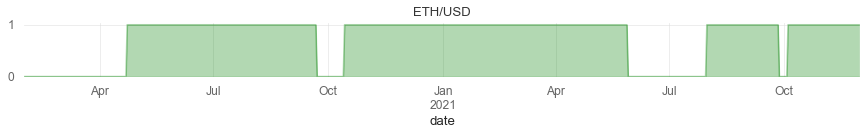

In [48]:
selected_df    =  port['20','40'] # fast , slow
selected_df.plot().show()

trend_kwargs = {"mamode": "ema", "fast": 20, "slow": 40}

# Entry Trade
benchmark_trends = _signal(benchmarkdf, **trend_kwargs)
benchmark_trends.copy().astype(int).plot(figsize=(15,1),kind='area',color=['green'],grid=True,alpha=0.3, title=f'{benchmarkdf.name}')

# port.from_orders(df.close).plot_trades()
# port.from_orders(df.close).plot_orders()



In [49]:
selected_df.plot_drawdowns().show()

selected_df.plot_underwater().show()
selected_df.plot_net_exposure().show()


In [ ]:
# # Exit Trade
# benchmark_trends_exit = _signal_exit(benchmarkdf, **trend_kwargs)
# benchmark_trends_exit.copy().astype(int).plot(figsize=(15,1),kind='area',color=['green'],grid=True,alpha=0.3, title=f'{benchmarkdf.name}')

# Report

In [50]:
# Benchmark Buy and Hold (BnH) Strategy
LIVE = 0

benchmarkpf_bnh = vbt.Portfolio.from_holding(benchmarkdf.close)
# print(benchmarkpf_bnh.trades.records[["status", "direction", "size", "entry_price", "exit_price", "return", "pnl", "entry_fees", "exit_fees"]])
bh_report = combine_stats(benchmarkpf_bnh, benchmarkdf.name, "MA  CRoss OVER", LIVE)
# Stretegy Report 
stg_report = combine_stats(selected_df, benchmarkdf.name, "MA  CRoss OVER", LIVE)
# selected_df.stats()


In [51]:
print('Compare  BuyNHold and Stg ')
print('='*100)
print(bh_report,'\n','='*100 ,)
print(stg_report)

Compare  BuyNHold and Stg 
Run Time                     Wednesday January 12, 2022, NYSE: 12:20:52
Mode                                                               TEST
Strategy                                                 MA  CRoss OVER
Direction                                                      longonly
Symbol                                                          ETH/USD
Fees [%]                                                           0.25
Slippage [%]                                                       0.25
Accumulate                                                        False
Start                                         2020-01-31 00:00:00+00:00
End                                           2021-12-01 00:00:00+00:00
Period                                                671 days 00:00:00
Start Value                                                     10000.0
End Value                                                 253973.688637
Total Return [%]                     

In [111]:
data =df
rec = port.trades.records_readable

for i,v in rec.iterrows():
    entry_t = rec.loc[i,'Entry Timestamp']
    exit_t = rec.loc[i,'Exit Timestamp']
    ent_p =  rec.loc[i,'Avg Entry Price']
    # call price df   to calculation
    rec.loc[i,'duration']= data.loc[entry_t:exit_t].shape[0] - 1
    mfe = (max(data[entry_t:exit_t].close) / ent_p) - 1 
    mae = (min(data[entry_t: exit_t].close) / ent_p) - 1 
    rec.loc[i,'mfe']= mfe
    rec.loc[i,'mae']= mae


rec


,Exit Trade Id,Column,Size,Entry Timestamp,Avg Entry Price,Entry Fees,Exit Timestamp,Avg Exit Price,Exit Fees,PnL,Return,Direction,Status,Position Id,duration,mfe,mae
0,0,"(10, 20)",38.499466,2020-02-19 00:00:00+00:00,259.096125,24.937656,2020-03-01 00:00:00+00:00,216.926325,20.878869,-1669.331288,-0.167350,Long,Closed,0,11.0,0.063505,-0.161238
1,1,"(10, 20)",50.353366,2020-04-07 00:00:00+00:00,165.031550,20.774735,2020-06-27 00:00:00+00:00,220.148250,27.713013,2726.823599,0.328142,Long,Closed,1,81.0,0.505167,-0.074177
2,2,"(10, 20)",45.511526,2020-07-06 00:00:00+00:00,242.354375,27.574794,2020-09-05 00:00:00+00:00,334.421850,38.050122,4124.506396,0.373938,Long,Closed,2,61.0,0.961590,-0.040248
3,3,"(10, 20)",40.354684,2020-10-11 00:00:00+00:00,375.275850,37.860346,2021-02-26 00:00:00+00:00,1440.390000,145.316208,42799.168454,2.826121,Long,Closed,3,138.0,4.215364,-0.025570
4,4,"(10, 20)",31.458828,2021-03-08 00:00:00+00:00,1838.484750,144.591439,2021-03-24 00:00:00+00:00,1577.047500,124.030166,-8493.131112,-0.146847,Long,Closed,4,16.0,0.045209,-0.140053
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
189,189,"(110, 130)",40.365870,2020-06-08 00:00:00+00:00,247.116250,24.937656,2021-12-01 00:00:00+00:00,4586.500000,0.000000,175138.061303,17.557591,Long,Open,189,541.0,18.467761,-0.106898
190,190,"(110, 140)",43.057626,2020-06-18 00:00:00+00:00,231.667725,24.937656,2021-12-01 00:00:00+00:00,4586.500000,0.000000,187483.803328,18.795251,Long,Open,190,531.0,19.765948,-0.047342
191,191,"(120, 130)",40.365870,2020-06-08 00:00:00+00:00,247.116250,24.937656,2021-12-01 00:00:00+00:00,4586.500000,0.000000,175138.061303,17.557591,Long,Open,191,541.0,18.467761,-0.106898
192,192,"(120, 140)",43.057626,2020-06-18 00:00:00+00:00,231.667725,24.937656,2021-12-01 00:00:00+00:00,4586.500000,0.000000,187483.803328,18.795251,Long,Open,192,531.0,19.765948,-0.047342


In [1]:
    
def Calculate_mae_mfe(data,port):
    MAE = []
    MFE = []
    for i,j,y,k in zip(port['Entry Timestamp'], port['Exit Timestamp'], port['Avg Entry Price'], port['Direction']):
        if k == 'Long':
            MFE.append(data.loc[i:j]['High'].max() - y)
            MAE.append(y - df.loc[i:j]['Low'].min())
        else :
            MAE.append(data.loc[i:j]['High'].max() - y)
            MFE.append(y - df.loc[i:j]['Low'].min())
    return MAE, MFE 

In [107]:
# rec.loc[0,'Entry Timestamp']
print(exit_t,entry_t)
rec


2021-12-01 00:00:00+00:00 2020-06-18 00:00:00+00:00


,Exit Trade Id,Column,Size,Entry Timestamp,Avg Entry Price,Entry Fees,Exit Timestamp,Avg Exit Price,Exit Fees,PnL,Return,Direction,Status,Position Id,duration,mfe,mae
0,0,"(10, 20)",38.499466,2020-02-19 00:00:00+00:00,259.096125,24.937656,2020-03-01 00:00:00+00:00,216.926325,20.878869,-1669.331288,-0.167350,Long,Closed,0,11,0.063505,-0.161238
1,1,"(10, 20)",50.353366,2020-04-07 00:00:00+00:00,165.031550,20.774735,2020-06-27 00:00:00+00:00,220.148250,27.713013,2726.823599,0.328142,Long,Closed,1,81,0.505167,-0.074177
2,2,"(10, 20)",45.511526,2020-07-06 00:00:00+00:00,242.354375,27.574794,2020-09-05 00:00:00+00:00,334.421850,38.050122,4124.506396,0.373938,Long,Closed,2,61,0.961590,-0.040248
3,3,"(10, 20)",40.354684,2020-10-11 00:00:00+00:00,375.275850,37.860346,2021-02-26 00:00:00+00:00,1440.390000,145.316208,42799.168454,2.826121,Long,Closed,3,138,4.215364,-0.025570
4,4,"(10, 20)",31.458828,2021-03-08 00:00:00+00:00,1838.484750,144.591439,2021-03-24 00:00:00+00:00,1577.047500,124.030166,-8493.131112,-0.146847,Long,Closed,4,16,0.045209,-0.140053
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
189,189,"(110, 130)",40.365870,2020-06-08 00:00:00+00:00,247.116250,24.937656,2021-12-01 00:00:00+00:00,4586.500000,0.000000,175138.061303,17.557591,Long,Open,189,541,18.467761,-0.106898
190,190,"(110, 140)",43.057626,2020-06-18 00:00:00+00:00,231.667725,24.937656,2021-12-01 00:00:00+00:00,4586.500000,0.000000,187483.803328,18.795251,Long,Open,190,531,19.765948,-0.047342
191,191,"(120, 130)",40.365870,2020-06-08 00:00:00+00:00,247.116250,24.937656,2021-12-01 00:00:00+00:00,4586.500000,0.000000,175138.061303,17.557591,Long,Open,191,541,18.467761,-0.106898
192,192,"(120, 140)",43.057626,2020-06-18 00:00:00+00:00,231.667725,24.937656,2021-12-01 00:00:00+00:00,4586.500000,0.000000,187483.803328,18.795251,Long,Open,192,531,19.765948,-0.047342


11

In [54]:
port.orders.records_readable

,Order Id,Column,Timestamp,Size,Price,Fees,Side
0,0,"(10, 20)",2020-02-19 00:00:00+00:00,38.499466,259.096125,24.937656,Buy
1,1,"(10, 20)",2020-03-01 00:00:00+00:00,38.499466,216.926325,20.878869,Sell
2,2,"(10, 20)",2020-04-07 00:00:00+00:00,50.353366,165.031550,20.774735,Buy
3,3,"(10, 20)",2020-06-27 00:00:00+00:00,50.353366,220.148250,27.713013,Sell
4,4,"(10, 20)",2020-07-06 00:00:00+00:00,45.511526,242.354375,27.574794,Buy
...,...,...,...,...,...,...,...
292,292,"(110, 130)",2020-06-08 00:00:00+00:00,40.365870,247.116250,24.937656,Buy
293,293,"(110, 140)",2020-06-18 00:00:00+00:00,43.057626,231.667725,24.937656,Buy
294,294,"(120, 130)",2020-06-08 00:00:00+00:00,40.365870,247.116250,24.937656,Buy
295,295,"(120, 140)",2020-06-18 00:00:00+00:00,43.057626,231.667725,24.937656,Buy


In [55]:
port_return = port.total_return().unstack('fast')
print(port.total_return().sort_values(ascending=False).head())
port_return
# port.total_return().unstack('fast')

fast  slow
80    100     20.708939
90    100     20.708939
20    70      20.412434
100   110     20.256944
70    110     20.256944
Name: total_return, dtype: float64


fast,10,20,30,40,50,60,70,80,90,100,110,120,130
slow,,,,,,,,,,,,,
20,9.159525,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
30,10.663465,16.665704,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
40,11.960913,15.848815,20.209695,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50,14.507356,16.729996,15.550847,16.149906,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
60,14.310161,16.603486,16.851214,13.022703,11.753960,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
70,13.826482,20.412434,16.609041,13.387131,9.604442,13.052144,NaN,NaN,NaN,NaN,NaN,NaN,NaN
80,15.571997,18.457456,13.015330,12.557620,12.359267,12.561146,12.074201,NaN,NaN,NaN,NaN,NaN,NaN
90,18.562274,18.246365,14.679329,12.829176,14.578677,13.070952,13.664637,15.495675,NaN,NaN,NaN,NaN,NaN
100,17.949881,14.536364,13.264494,14.660737,14.459639,14.514898,14.152271,20.708939,20.708939,NaN,NaN,NaN,NaN


In [59]:
df1 =pd.DataFrame((port.total_return().sort_values(ascending=False)))
df1

,,total_return
fast,slow,
80,100,20.708939
90,100,20.708939
20,70,20.412434
100,110,20.256944
70,110,20.256944
...,...,...
10,40,11.960913
50,60,11.753960
10,30,10.663465


[Text(0.5, 1.0, 'ETH/USD 2020-01-31 To  2021-12-01')]

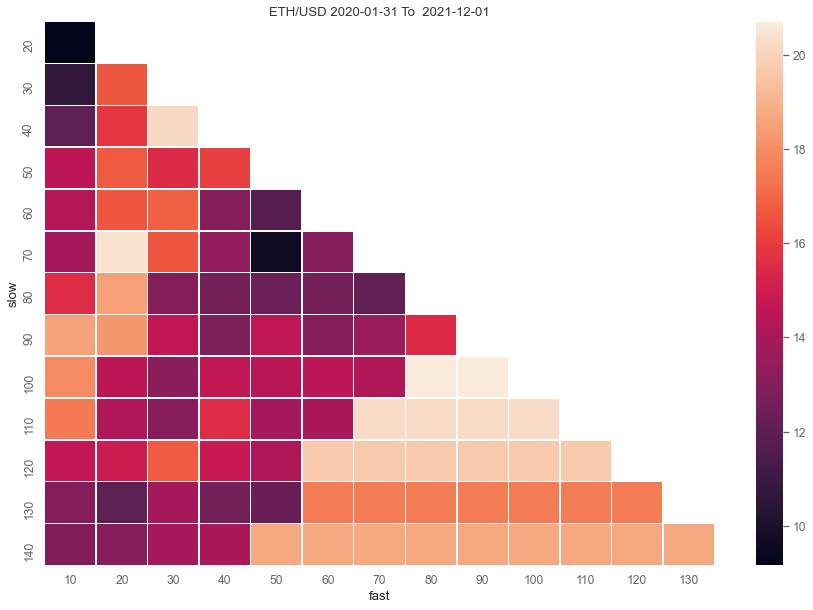

In [57]:
fig, ax = plt.subplots(figsize=(15,10))         # Sample figsize in inches

sns.heatmap(data=port_return,linewidths=0.5).set(title=df.name+" "+start_date.strftime('%Y-%m-%d') +" To  "+end_date.strftime('%Y-%m-%d'))
